## Advanced Graphs

Prequisites:

 - A running Kubernetes cluster
 - [Git clone of Seldon Core](https://github.com/SeldonIO/seldon-core)
 - [Helm](https://github.com/kubernetes/helm)

In this notebook we will illustrate the different types of microservices that can be deployed in Seldon:
* Model
* Transformer
* Router
* Combiner
* Output Transformer

We will deploy graphs of increasing complexity. But first we need to install seldon on the cluster.

If running via Minikube you may need to ensure you have cluster-admin rights

In [21]:
!!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

['clusterrolebinding "kube-system-cluster-admin" created']

In [1]:
!kubectl -n kube-system create sa tiller
!kubectl create clusterrolebinding tiller --clusterrole cluster-admin --serviceaccount=kube-system:tiller
!helm init --service-account tiller

serviceaccount "tiller" created
clusterrolebinding "tiller" created
$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [4]:
!helm install ../helm-charts/seldon-core-crd --name seldon-core-crd --set usage_metrics.enabled=true

NAME:   seldon-core-crd
LAST DEPLOYED: Fri Sep  7 16:53:30 2018
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1/ConfigMap
NAME                     DATA  AGE
seldon-spartakus-config  3     0s

==> v1beta1/CustomResourceDefinition
NAME                                         AGE
seldondeployments.machinelearning.seldon.io  0s

==> v1beta1/Deployment
NAME                        DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-spartakus-volunteer  1        0        0           0          0s

==> v1/ServiceAccount
NAME                        SECRETS  AGE
seldon-spartakus-volunteer  1        0s

==> v1beta1/ClusterRole
NAME                        AGE
seldon-spartakus-volunteer  0s

==> v1beta1/ClusterRoleBinding
NAME                        AGE
seldon-spartakus-volunteer  0s


NOTES:
NOTES: TODO




In [5]:
!kubectl create namespace graphs

namespace "graphs" created


In [16]:
!helm install ../helm-charts/seldon-core --name seldon-core \
        --set cluster_manager.rbac=true \
        --namespace graphs

NAME:   seldon-core
LAST DEPLOYED: Fri Sep  7 17:05:59 2018
NAMESPACE: graphs
STATUS: DEPLOYED

RESOURCES:
==> v1/ClusterRoleBinding
NAME    AGE
seldon  1s

==> v1beta1/Role
NAME          AGE
seldon-local  1s

==> v1/RoleBinding
NAME    AGE
seldon  1s

==> v1/Service
NAME                          TYPE       CLUSTER-IP    EXTERNAL-IP  PORT(S)                        AGE
seldon-core-seldon-apiserver  NodePort   10.110.68.62  <none>       8080:30024/TCP,5000:32281/TCP  1s
seldon-core-redis             ClusterIP  10.101.74.51  <none>       6379/TCP                       1s

==> v1beta1/Deployment
NAME                                DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-core-seldon-apiserver        1        1        1           0          1s
seldon-core-seldon-cluster-manager  1        1        1           0          1s
seldon-core-redis                   1        1        1           0          1s

==> v1/Pod(related)
NAME                                                 READY 

## Set up REST and gRPC methods

**Ensure you port forward the seldon api-server REST and GRPC ports**:

REST:
```
kubectl port-forward $(kubectl get pods -n graphs -l app=seldon-apiserver-container-app -o jsonpath='{.items[0].metadata.name}') -n graphs 8002:8080
```

GRPC:
```
kubectl port-forward $(kubectl get pods -n graphs -l app=seldon-apiserver-container-app -o jsonpath='{.items[0].metadata.name}') -n graphs 8003:5000
```

In [7]:
!cp ../proto/prediction.proto ./proto
!python -m grpc.tools.protoc -I. --python_out=. --grpc_python_out=. ./proto/prediction.proto

In [1]:
from visualizer import get_graph
import json
from seldon_utils import *
API_GATEWAY_REST="localhost:8002"
API_GATEWAY_GRPC="localhost:8003"

## Simple Model

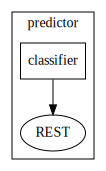

In [9]:
get_graph("resources/model.json")

First we will check that everything works by running a simple model

In [18]:
!kubectl apply -f resources/model.json -n graphs

seldondeployment "seldon-model" created


In [19]:
!kubectl get seldondeployments seldon-model -o jsonpath="{.status}" -n graphs

map[predictorStatus:[map[name:test-deployment-example-svc-orch replicas:1 replicasAvailable:1] map[replicas:1 replicasAvailable:1 name:test-deployment-example-classifier-0]]]

In [22]:
rest_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":43199,"scope":"read write"}
{
  "meta": {
    "puid": "451qsqv560121tt9skumrg0top",
    "tags": {
    },
    "routing": {
    }
  },
  "data": {
    "names": ["proba"],
    "tensor": {
      "shape": [1, 1],
      "values": [0.07829565259771333]
    }
  }
}


In [23]:
grpc_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST,API_GATEWAY_GRPC)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":43179,"scope":"read write"}
meta {
  puid: "4jlaasifq85i9cvc6s44pnorln"
}
data {
  names: "proba"
  tensor {
    shape: 1
    shape: 1
    values: 0.09835821473688332
  }
}



In [24]:
!kubectl delete -f resources/model.json -n graphs

seldondeployment "seldon-model" deleted


## Random AB Test

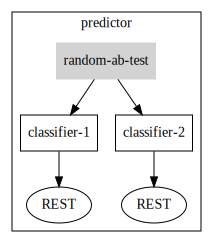

In [25]:
get_graph("resources/random_ab_test.json")

In this example we will deploy 2 models under an AB test router. The Random AB Test we will use is implemented directly in Seldon, this is not a microservice, so no docker image needs to be specified.

The json graph is as follows:

In [26]:
json.load(open("./resources/random_ab_test.json",'r')).get("spec").get("predictors")[0].get("graph")

{'children': [{'children': [],
   'endpoint': {'type': 'REST'},
   'name': 'classifier-1',
   'type': 'MODEL'},
  {'children': [],
   'endpoint': {'type': 'REST'},
   'name': 'classifier-2',
   'type': 'MODEL'}],
 'endpoint': {},
 'implementation': 'RANDOM_ABTEST',
 'name': 'random-ab-test',
 'parameters': [{'name': 'ratioA', 'type': 'FLOAT', 'value': '0.5'}]}

We specify ``` "implementation": "RANDOM_ABTEST" ``` to get the AB Test router implemented in Seldon.
We pass the parameter ratioA which corresponds to the ratio of requests that will be passed to the first child of the Router

In [27]:
!kubectl apply -f resources/random_ab_test.json -n graphs

seldondeployment "seldon-deployment" created


In [29]:
!kubectl get seldondeployments seldon-deployment -o jsonpath='{.status}' -n graphs

map[predictorStatus:[map[name:test-deployment-abtest-abtest-svc-orch replicas:1 replicasAvailable:1] map[name:test-deployment-abtest-abtest-classifier-1-0 replicas:1 replicasAvailable:1] map[name:test-deployment-abtest-abtest-classifier-2-1 replicas:1 replicasAvailable:1]]]

In [30]:
rest_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":43047,"scope":"read write"}
{
  "meta": {
    "puid": "bvhqfc5mc19ubfm5sjv2hotv1e",
    "tags": {
    },
    "routing": {
      "random-ab-test": 1
    }
  },
  "data": {
    "names": ["proba"],
    "tensor": {
      "shape": [1, 1],
      "values": [0.0869949501192126]
    }
  }
}


In [31]:
grpc_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST,API_GATEWAY_GRPC)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":43033,"scope":"read write"}
meta {
  puid: "4v9kklilc2nnrhpjurbevnn3ni"
  routing {
    key: "random-ab-test"
  }
}
data {
  names: "proba"
  tensor {
    shape: 1
    shape: 1
    values: 0.08726940781776818
  }
}



In [32]:
!kubectl delete -f resources/random_ab_test.json -n graphs

seldondeployment "seldon-deployment" deleted


## Average Combiner

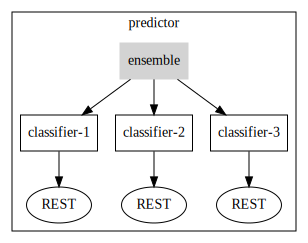

In [33]:
get_graph("resources/ensemble.json")

In this example again we will use a service implemented in seldon, called Average Combiner. It takes the outputs of several models and returns the arithmetic mean of them.

The json is as follows:

In [34]:
json.load(open("./resources/ensemble.json",'r')).get("spec").get("predictors")[0].get("graph")

{'children': [{'endpoint': {'type': 'REST'},
   'name': 'classifier-1',
   'type': 'MODEL'},
  {'endpoint': {'type': 'REST'}, 'name': 'classifier-2', 'type': 'MODEL'},
  {'endpoint': {'type': 'REST'}, 'name': 'classifier-3', 'type': 'MODEL'}],
 'implementation': 'AVERAGE_COMBINER',
 'name': 'ensemble'}

In [35]:
!kubectl apply -f resources/ensemble.json -n graphs

seldondeployment "seldon-deployment" created


In [36]:
!kubectl get seldondeployments seldon-deployment -o jsonpath='{.status}' -n graphs

map[predictorStatus:[map[name:test-deployment-ensembles-ensemble-classifier-1-0 replicas:1 replicasAvailable:1] map[name:test-deployment-ensembles-ensemble-svc-orch replicas:1 replicasAvailable:1]]]

In [37]:
rest_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":42817,"scope":"read write"}
{
  "status": {
    "code": 0,
    "info": "",
    "reason": "",
    "status": "SUCCESS"
  },
  "meta": {
    "puid": "6brqopn2kgj2mei19v62u1s1o2",
    "tags": {
    },
    "routing": {
      "ensemble": -1
    }
  },
  "data": {
    "names": ["proba"],
    "tensor": {
      "shape": [1, 1],
      "values": [0.06432655349966468]
    }
  }
}


In [38]:
grpc_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST,API_GATEWAY_GRPC)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":42804,"scope":"read write"}
status {
}
meta {
  puid: "4qdusjsnvfelfapekc4a41n048"
  routing {
    key: "ensemble"
    value: -1
  }
}
data {
  names: "proba"
  tensor {
    shape: 1
    shape: 1
    values: 0.09087465642287341
  }
}



In [39]:
!kubectl delete -f resources/ensemble.json -n graphs

seldondeployment "seldon-deployment" deleted


## Feature Transformer

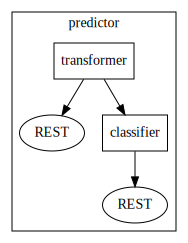

In [40]:
get_graph("resources/feature_transform.json")

In this example we deploy a simple model under a feature transformation microservice. For the transformer we will use the docker image seldonio/mock_transformer:1.0

Since this is not implemented in Seldon, the type of predictive unit (TRANSFORMER) needs to be specified in the graph so that Seldon Core knows which API this microservice implements.

The json is as follows:

In [41]:
json.load(open("./resources/feature_transform.json",'r')).get("spec").get("predictors")[0].get("graph")

{'children': [{'endpoint': {'type': 'REST'},
   'name': 'classifier',
   'type': 'MODEL'}],
 'endpoint': {'type': 'REST'},
 'name': 'transformer',
 'type': 'TRANSFORMER'}

In [43]:
!kubectl apply -f resources/feature_transform.json -n graphs

seldondeployment "seldon-deployment" created


In [44]:
!kubectl get seldondeployments seldon-deployment -o jsonpath='{.status}' -n graphs

map[predictorStatus:[map[replicasAvailable:1 name:test-deployment-transformer-transformer-svc-orch replicas:1] map[name:test-deployment-transformer-transformer-classifier-0 replicas:1 replicasAvailable:1]]]

In [45]:
rest_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":42676,"scope":"read write"}
{
  "meta": {
    "puid": "609lofmkg4lsulscaaenoh1igs",
    "tags": {
    },
    "routing": {
      "transformer": -1
    }
  },
  "data": {
    "names": ["proba"],
    "tensor": {
      "shape": [1, 1],
      "values": [0.07725291332801949]
    }
  }
}


In [46]:
grpc_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST,API_GATEWAY_GRPC)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":42660,"scope":"read write"}
meta {
  puid: "1lofl8bsm4udb5ch15cuvgr4c9"
  routing {
    key: "transformer"
    value: -1
  }
}
data {
  names: "proba"
  tensor {
    shape: 1
    shape: 1
    values: 0.08068693474059799
  }
}



In [47]:
!kubectl delete -f resources/feature_transform.json -n graphs

seldondeployment "seldon-deployment" deleted


## Outlier Detector

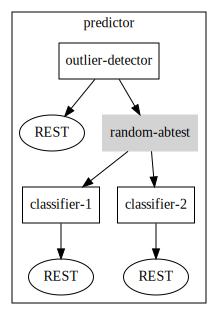

In [48]:
get_graph("resources/outlier_detector.json")

In this example we will have different four components: 
* A transformer, the outlier detector
* A router, the random AB test
* Two models

The outlier detector is a special kind of transformer that will populate a tag in the response metadata with the outlier score it has calculated. 
We use the docker image seldonio/outlier_mahalanobis:0.2 for the outlier detector.

The json is as follows:

In [49]:
json.load(open("./resources/outlier_detector.json",'r')).get("spec").get("predictors")[0].get("graph")

{'children': [{'children': [{'endpoint': {'type': 'REST'},
     'name': 'classifier-1',
     'type': 'MODEL'},
    {'endpoint': {'type': 'REST'}, 'name': 'classifier-2', 'type': 'MODEL'}],
   'implementation': 'RANDOM_ABTEST',
   'name': 'random-abtest',
   'parameters': [{'name': 'ratioA', 'type': 'FLOAT', 'value': '0.5'}],
   'type': 'UNKNOWN_TYPE'}],
 'endpoint': {'type': 'REST'},
 'name': 'outlier-detector',
 'type': 'TRANSFORMER'}

In [5]:
!kubectl apply -f resources/outlier_detector.json -n graphs

seldondeployment "seldon-deployment" created


In [6]:
!kubectl get seldondeployments seldon-deployment -o jsonpath='{.status}' -n graphs

map[predictorStatus:[map[name:test-deployment-complex-outlier-svc-orch replicas:1 replicasAvailable:1] map[name:test-deployment-complex-outlier-classifier-1-0 replicas:1 replicasAvailable:1] map[name:test-deployment-complex-outlier-outlier-detector-1 replicas:1 replicasAvailable:1]]]

In [7]:
rest_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":41909,"scope":"read write"}
{
  "meta": {
    "puid": "t4rbm3rk6b39ik542tn0tq91ns",
    "tags": {
      "outlierScore": [0.0, 0.0]
    },
    "routing": {
      "outlier-detector": -1,
      "random-abtest": 1
    }
  },
  "data": {
    "names": ["proba"],
    "tensor": {
      "shape": [2, 1],
      "values": [0.08451014845764081, 0.08581033201511856]
    }
  }
}


In [8]:
grpc_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST,API_GATEWAY_GRPC)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":41896,"scope":"read write"}
meta {
  puid: "p4vvcd4a78v7ij3d3hvjbc9i0n"
  tags {
    key: "outlierScore"
    value {
      list_value {
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
      }
    }
  }
  routing {
    key: "outlier-detector"
    value: -1
  }
  routing {
    key: "random-abtest"
  }
}
data {
  names: "proba"
  tensor {
    shape: 2
    shape: 1
    values: 0.07959244469471599
    values: 0.07167298063671615
  }
}



In [9]:
!kubectl delete -f resources/outlier_detector.json -n graphs

seldondeployment "seldon-deployment" deleted


## Complex Graph

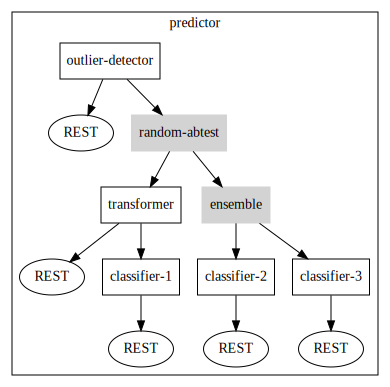

In [10]:
get_graph("resources/complex_graph.json")

In this final example we will deploy a complex graph with all of the components that have been used so far.

In [11]:
!kubectl apply -f resources/complex_graph.json -n graphs

seldondeployment "seldon-deployment" created


In [13]:
!kubectl get seldondeployments seldon-deployment -o jsonpath='{.status}' -n graphs

map[predictorStatus:[map[name:test-deployment-complex-complex-svc-orch replicas:1 replicasAvailable:1] map[replicasAvailable:1 name:test-deployment-complex-complex-classifier-1-0 replicas:1] map[name:test-deployment-complex-complex-classifier-2-1 replicas:1 replicasAvailable:1] map[name:test-deployment-complex-complex-classifier-3-2 replicas:1 replicasAvailable:1] map[name:test-deployment-complex-complex-transformer-4 replicas:1 replicasAvailable:1] map[name:test-deployment-complex-complex-outlier-detector-3 replicas:1 replicasAvailable:1]]]

In [15]:
rest_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":41760,"scope":"read write"}
{
  "status": {
    "code": 0,
    "info": "",
    "reason": "",
    "status": "SUCCESS"
  },
  "meta": {
    "puid": "o5l2cpfqjijoaa4ormjbskipql",
    "tags": {
      "outlierScore": 0.9008780576448335
    },
    "routing": {
      "outlier-detector": -1,
      "ensemble": -1,
      "random-abtest": 1
    }
  },
  "data": {
    "names": ["proba"],
    "tensor": {
      "shape": [2, 1],
      "values": [0.09485971576799879, 0.08104735785381909]
    }
  }
}


In [16]:
grpc_request_api_gateway("oauth-key","oauth-secret",API_GATEWAY_REST,API_GATEWAY_GRPC)

{"access_token":"de4efb0c-0166-4d95-b1e6-bd096748842d","token_type":"bearer","expires_in":41747,"scope":"read write"}
meta {
  puid: "iffpdo8ouq2ehpqbhluav89g6a"
  tags {
    key: "outlierScore"
    value {
      number_value: 0.5414579901687784
    }
  }
  routing {
    key: "outlier-detector"
    value: -1
  }
  routing {
    key: "random-abtest"
  }
  routing {
    key: "transformer"
    value: -1
  }
}
data {
  names: "proba"
  tensor {
    shape: 2
    shape: 1
    values: 0.08611808920667463
    values: 0.08029119284002609
  }
}



In [17]:
!kubectl delete -f resources/complex_graph.json -n graphs

seldondeployment "seldon-deployment" deleted


## Tear Down

In [18]:
!helm delete seldon-core --purge

release "seldon-core" deleted


In [19]:
!helm delete seldon-core-crd --purge

release "seldon-core-crd" deleted
